## Glob paths to my DEMs.

In [1]:
import glob
from concurrent.futures import ThreadPoolExecutor
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
path_list = glob.glob('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/watersheds/*')
csv_list = glob.glob('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/csvs/*')

In [2]:
"""
Makes CSVS, PNGS, and TIFFs for each watershed in the path_list.
"""
# i=0
# for path in path_list:
#     !python /sciclone/home/ntlewis/Nick-Lewis-Research/working_files/py_scripts/relief.py x x x x watersheds/{path} pngs/output_{i}.png csvs/relief_{i}.csv
#     i+=1

'\nMakes CSVS, PNGS, and TIFFs for each watershed in the path_list.\n'

In [3]:
"""
Reads VA and WV geology shapefiles, combines them, and sets the CRS.
"""

geol_va = gpd.read_file('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/peripherals/geology/VA/VA_geol_poly.shp')
geol_wv = gpd.read_file('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/peripherals/geology/WV/WV_geol_poly.shp')
geol = pd.concat([geol_va, geol_wv])
geol = gpd.GeoDataFrame(geol, geometry=geol.geometry)
goal_crs = geol.crs

In [4]:
"""
Reads VA and WV physiographic regions shapefiles, combines them.
"""

va_regions = gpd.read_file('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/peripherals/regions/VA/Virginia_Physiographic_Regions.shp').to_crs(goal_crs)
wv_regions = gpd.read_file('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/peripherals/regions/wv_physio_FeaturesToJSON.geojson').to_crs(goal_crs)
regions = pd.concat([va_regions, wv_regions])
regions = gpd.GeoDataFrame(regions, geometry=regions.geometry)

In [5]:
"""
Reads a CSV file and converts it to a GeoDataFrame.
"""
def make_df(path):
    gdf = gpd.GeoDataFrame(data = pd.read_csv(path, index_col = 0))
    gdf.set_geometry(gpd.points_from_xy(gdf.East, gdf.North), inplace=True)
    gdf = gdf.set_crs(goal_crs)
    gdf = gdf.drop(columns=['y', 'max_y', 'x', 'max_x', 'rank'])
    return gdf

with ThreadPoolExecutor() as executor:
    results_iter = executor.map(make_df, csv_list)
    results = list(results_iter)

In [6]:
"""
Algorith for determining relict points.
"""

#Making series for determining relief and elevation boundaries for relict landscape.

relief = pd.Series()
avg_elev = pd.Series()
for res in results:
    relief = pd.concat([relief, res.Relief], ignore_index=True)
    avg_elev = pd.concat([avg_elev, res.avg_elevation], ignore_index=True)

#Now to set boundary conditions

i=0
for res in results:
    min_el = avg_elev.quantile(0.85)
    max_r = relief.quantile(0.15)
    res['relict'] = [True if res.Relief.iloc[i] <= max_r and res.avg_elevation.iloc[i] >= max_r else False for i in range(len(res))]
    res['basin'] = i
    i+=1

/local/scr/ntlewis/TMPDIR/ipykernel_3713336/186784252.py:10: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  relief = pd.concat([relief, res.Relief], ignore_index=True)
/local/scr/ntlewis/TMPDIR/ipykernel_3713336/186784252.py:11: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  avg_elev = pd.concat([avg_elev, res.avg_elevation], ignore_index=True)


In [7]:
# Retrun dfs of points with relict characteristics.  They also must be in one of the two selected provinces.

selected_points = []
for res in results:
    res = gpd.sjoin(res, regions[['PROVINCE', 'geometry']], how='left')
    res.drop(columns=['index_right'], inplace=True)
    selected_points.append(res[res.relict == True][res.PROVINCE.isin(['APPALACHIAN PLATEAUS', 'BLUE RIDGE'])])

/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/geopandas/geodataframe.py:1896: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/geopandas/geodataframe.py:1896: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/geopandas/geodataframe.py:1896: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/geopandas/geodataframe.py:1896: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/geopandas/geodataframe.p

In [8]:
# Index represents basins that contain relict landscape in selected provinces.

index = [3,5,6,7,8,9,10,11,15,16,17,18,21,22]
selected_basins = [path_list[i] for i in index]

Basemap loaded.
Did one...Did one...

Did one...
Did one...
Did one...
Did one...
Did one...
Did one...
Did one...
Did one...
Did one...
Did one...
Did one...Did one...



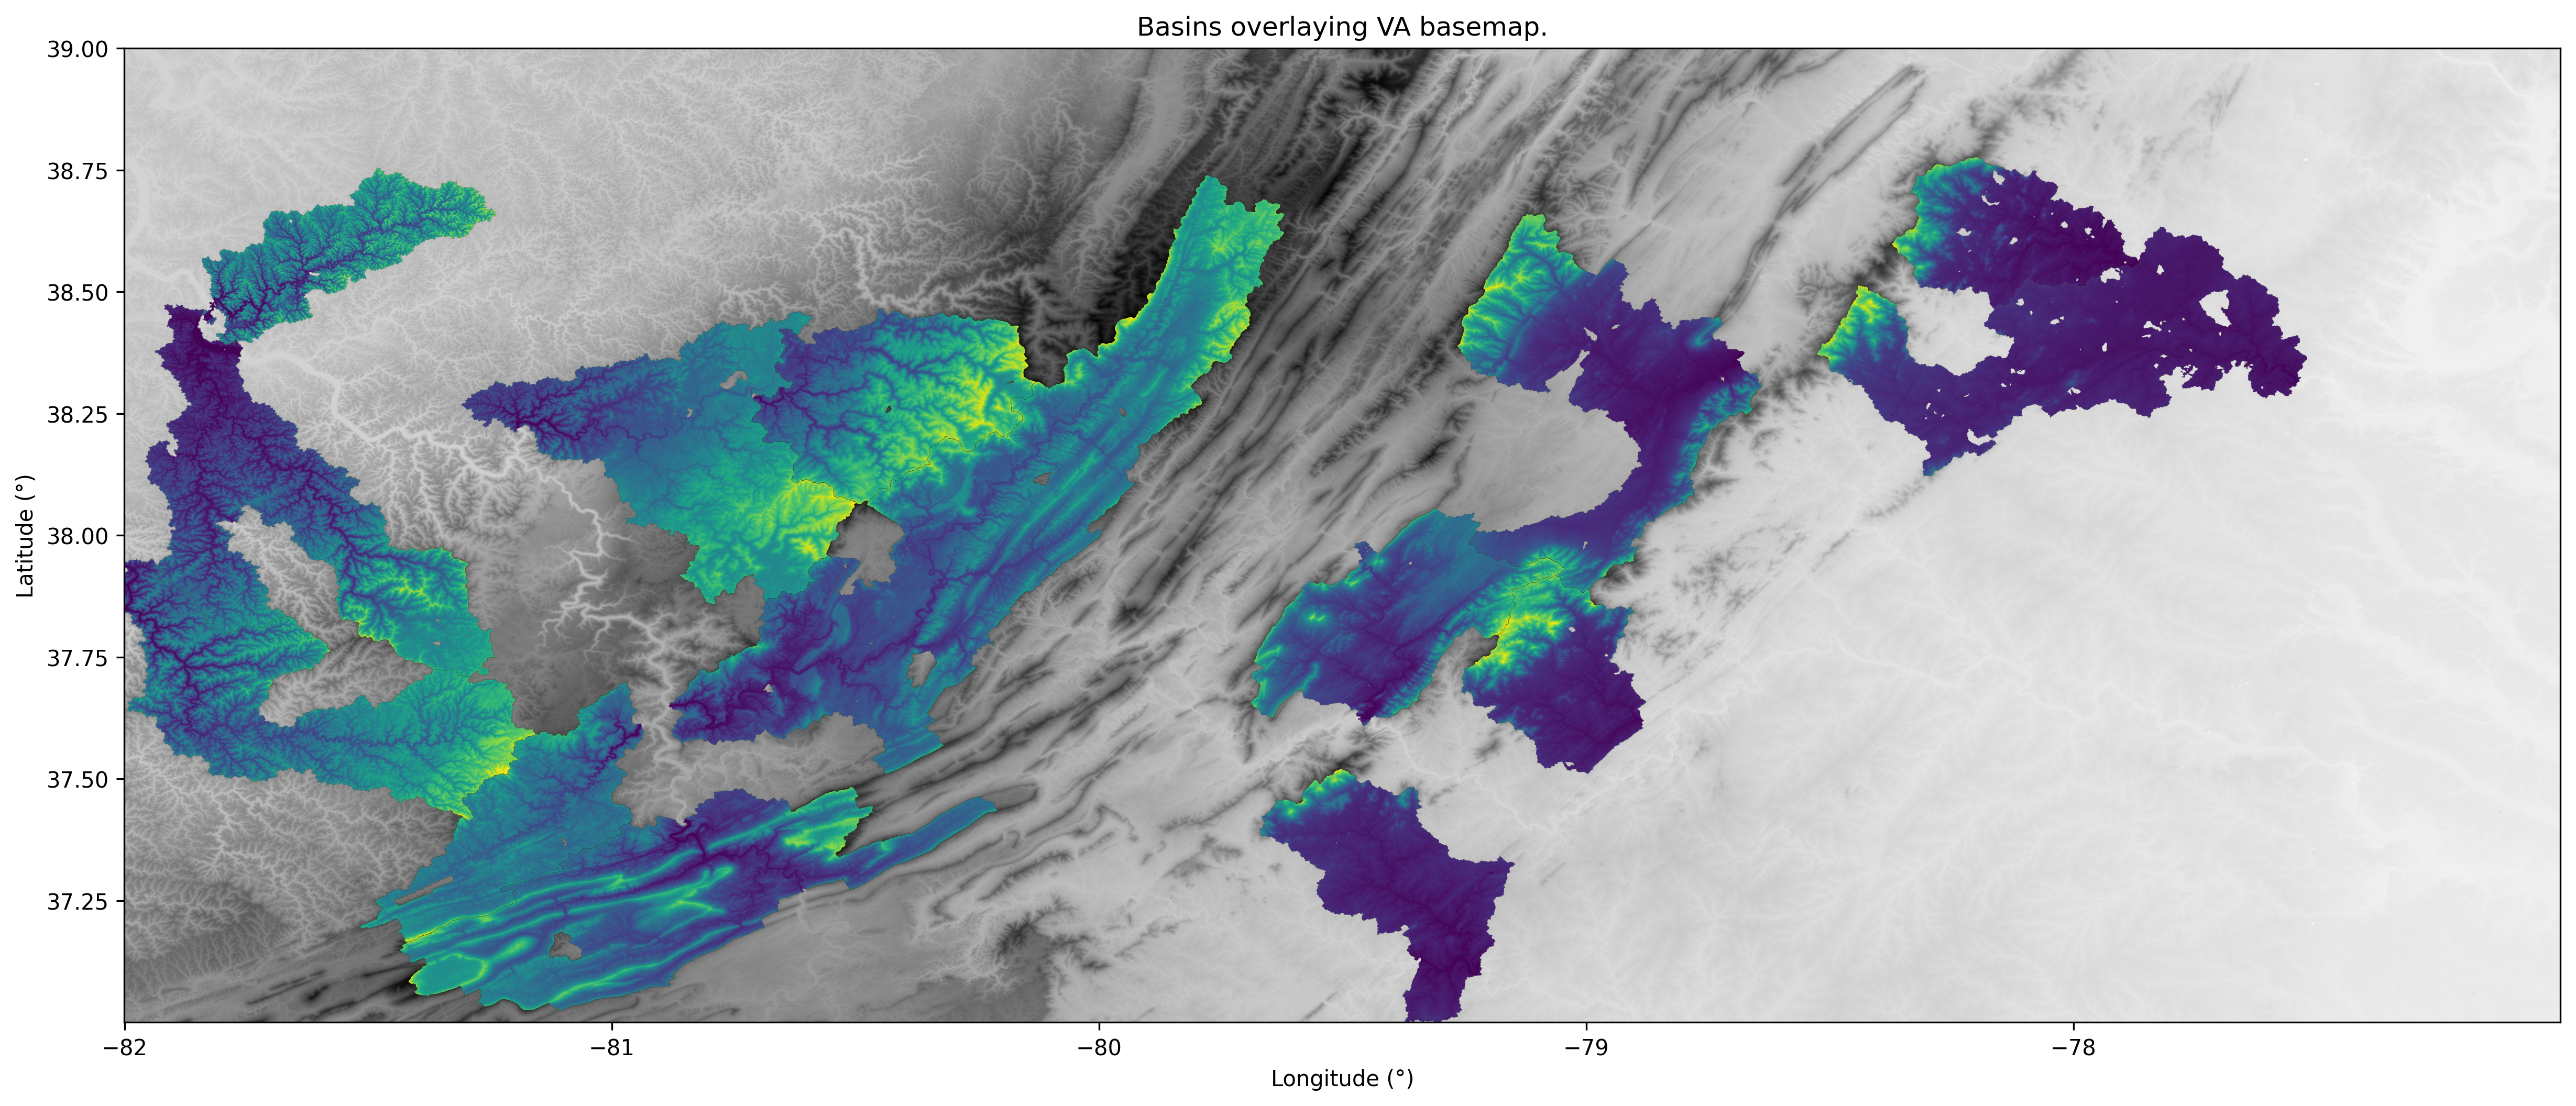

In [9]:
# Plot making.  Switch selected basins with path list in order to view all basins not just good ones.

def mk_plot(path):
    show(rasterio.open(path), ax=ax)
    print('Did one...')

with ThreadPoolExecutor() as executor:
    fig, ax = plt.subplots(figsize=(20,20), dpi=300)
    ax.set_title('Basins overlaying VA basemap.')
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Latitude (°)')
    with rasterio.open('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/get_basins.tiff') as src:
        basemap = show(src, cmap='binary', ax=ax)
        print('Basemap loaded.')
    executor.map(mk_plot, selected_basins)

In [35]:
def map_relict(i, ax):
    ax.set_title(f'Basin {i} mapped')
    src = rasterio.open(path_list[i])
    basin = show(src, ax=ax)
    df = selected_points[i]
    relict = sns.scatterplot(data=df, x='East', y='North', hue='Relief', ax=ax, legend=False)
    plt.show()

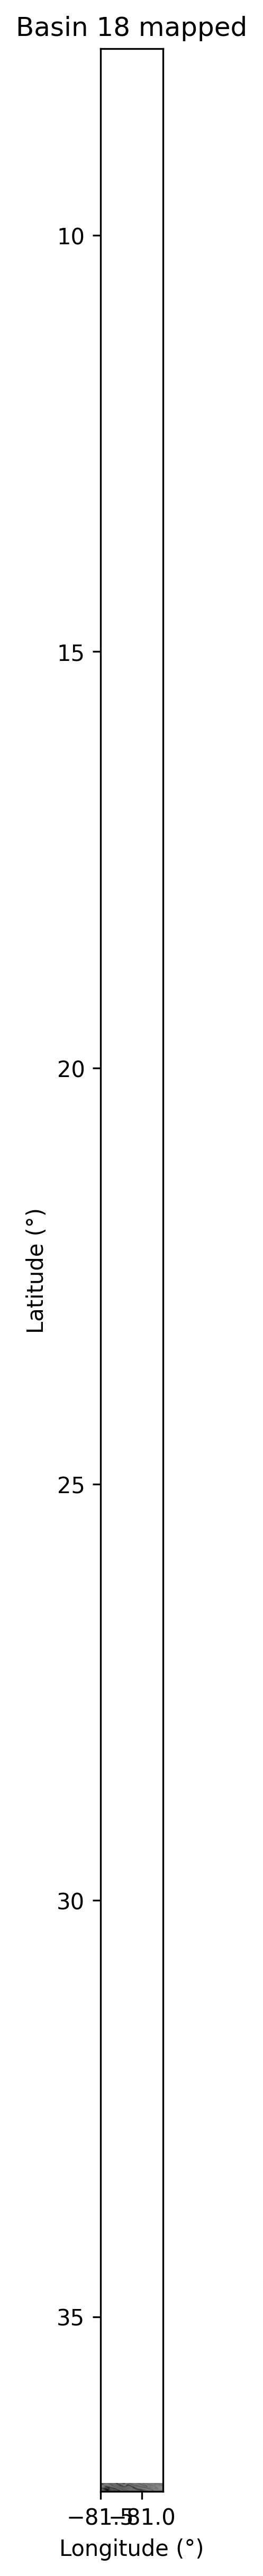

In [65]:
fig, ax = plt.subplots(figsize=(20,20),dpi=300)
base = rasterio.open('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/get_basins.tiff')
basemap = show(base, ax=ax, cmap='binary')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.set_ylim(top=7.758, bottom=37.1)
ax.set_xlim(left=-81.5,right=-80.75)
map_relict(index[11], ax)